In [1]:
# Sample solution is based on nontebooks by Artem Borzov

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load Datasets

In [2]:
train = pd.read_hdf('training/open30.h5') # pick just a single brick
test = pd.read_hdf('test/test.h5')

In [3]:
test = test.reset_index(drop=True)

In [4]:
test.head()

TX        TY             X             Y        Z  data_ind
0  0.087240  0.119438  86536.218750  62988.312500  56892.0         0
1 -0.380208  0.198382  93346.765625  58062.937500  14223.0         0
2 -0.348549 -0.099981  66129.578125  23038.673828  46548.0         0
3  0.585342 -0.126879  68825.523438  55186.625000  45255.0         0
4  0.038579 -0.131510  36366.941406  47564.878906   9051.0         0

In [5]:
train.head()

TX        TY             X             Y        Z  event_id  signal  \
0 -0.248382  0.072824  37014.070312  38318.898438  31032.0    -999.0     0.0   
1  0.768548  0.490205  46626.425781  15151.117188  72408.0  188918.0     1.0   
2 -0.132050 -0.049405  54031.640625  69132.320312  60771.0    -999.0     0.0   
3  0.260584  0.207106  56653.531250  35025.765625  43962.0    -999.0     0.0   
4  0.267597  0.111272  42231.714844  47199.027344  20688.0    -999.0     0.0   

   data_ind  
0        21  
1        21  
2        21  
3        21  
4        21

Посмотрим как выглядят ливни внутри одного data_ind

In [6]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

In [7]:
first = train.loc[train.data_ind == 21, :]

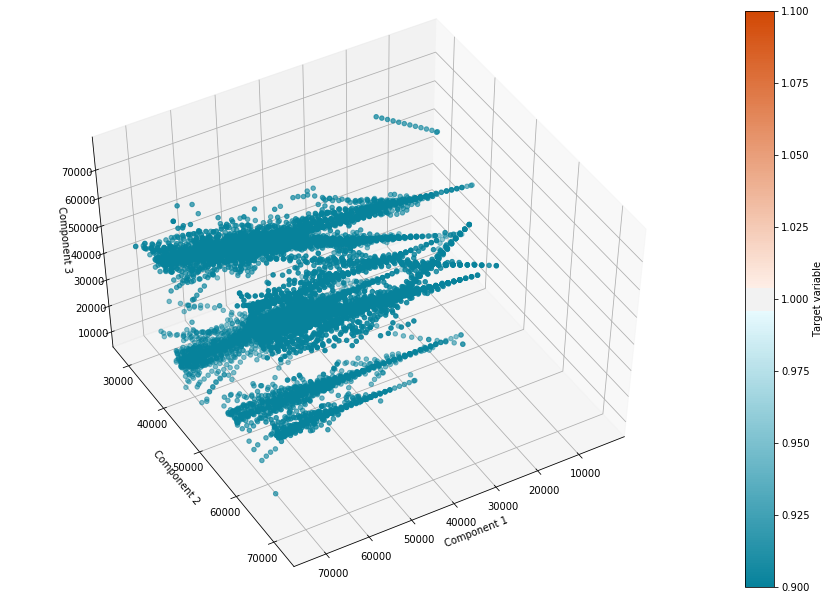

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=50, azim=60)

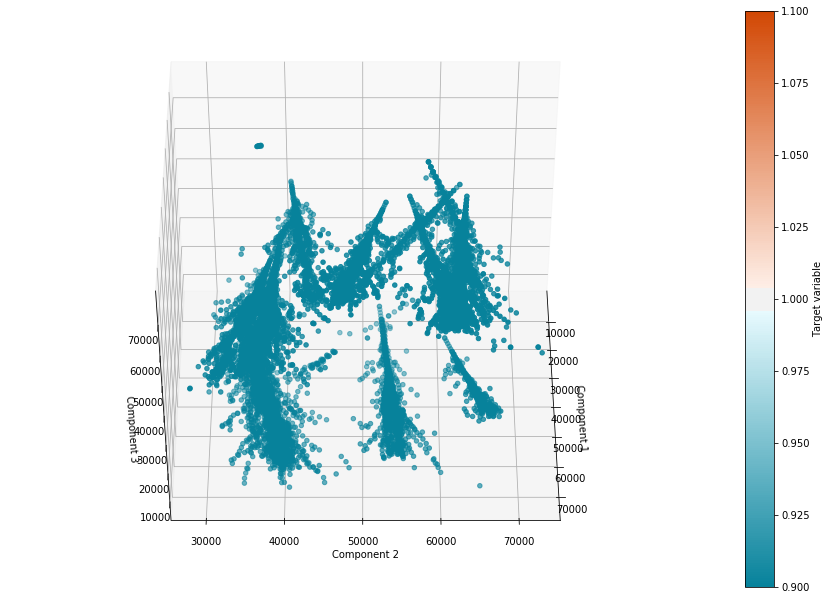

In [9]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

## Let's take a look at basetrack distribution along the axis

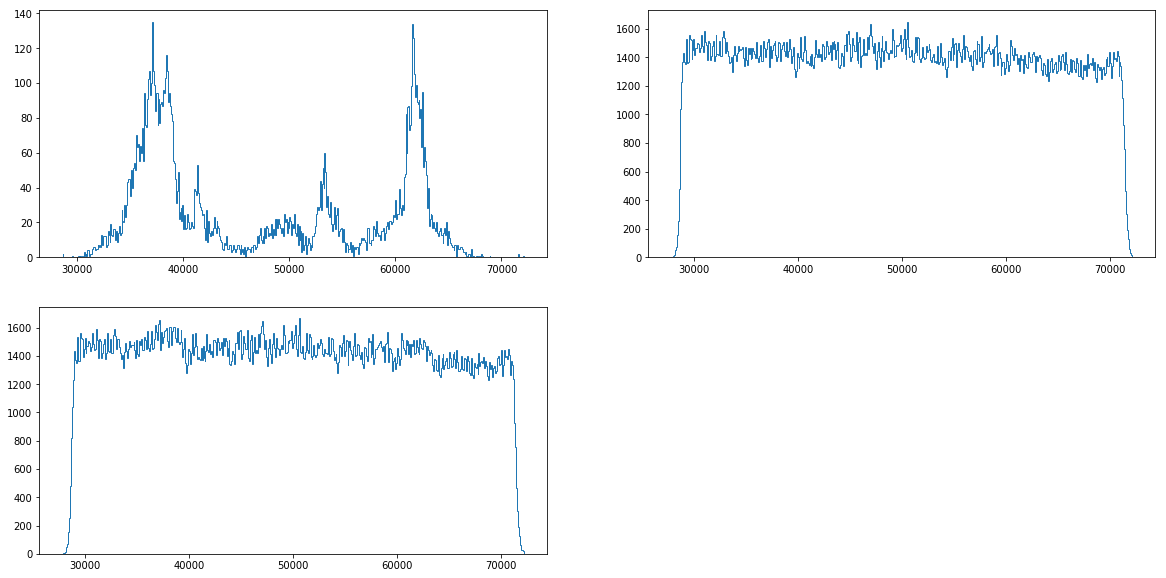

In [10]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

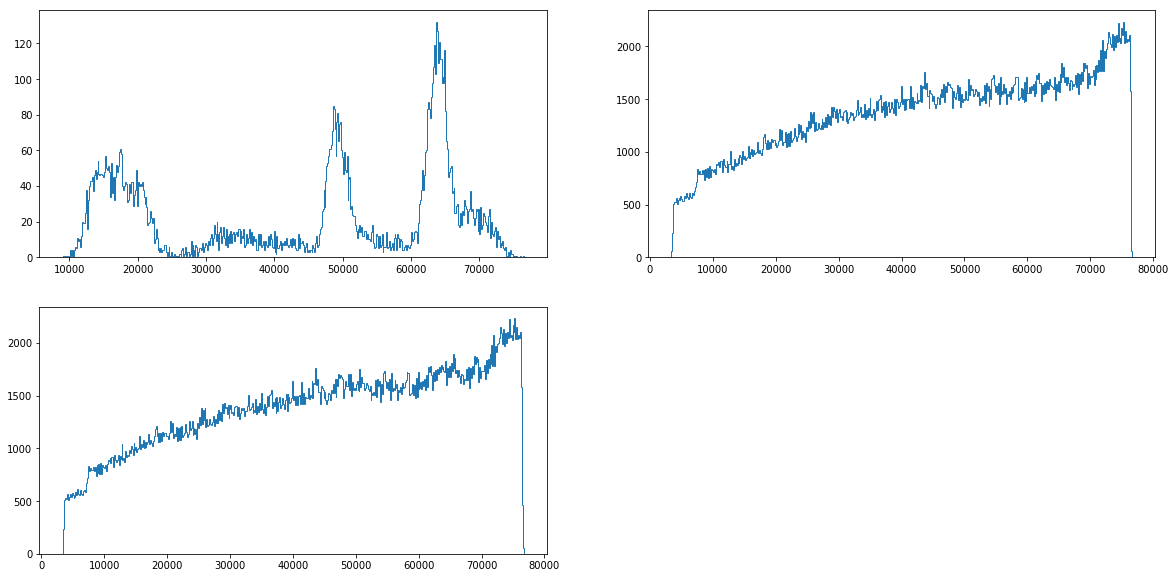

In [11]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

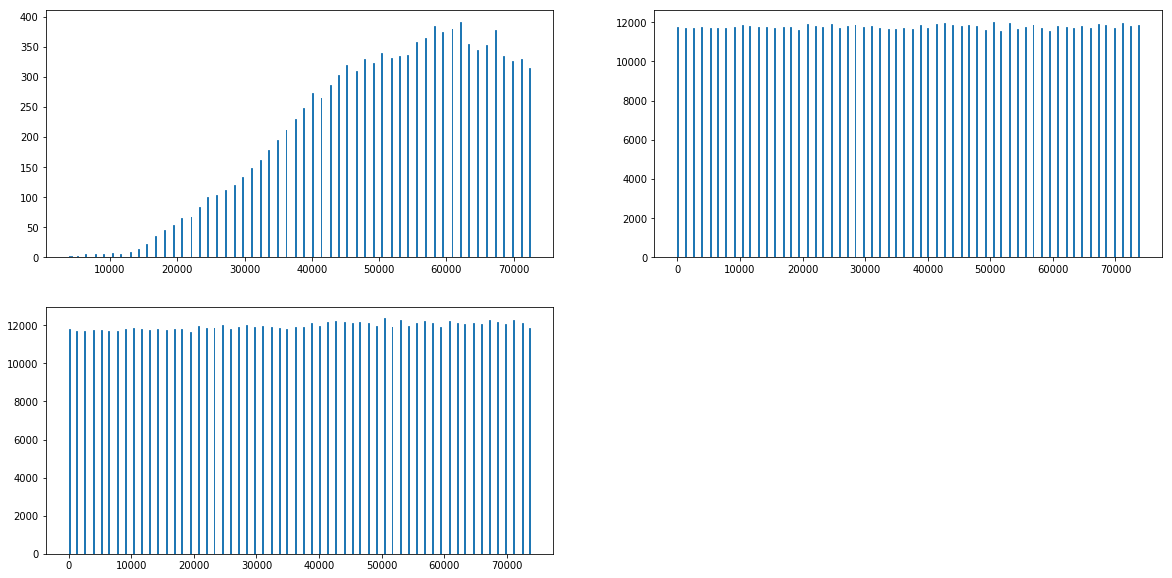

In [12]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

# Let's group close tracks from neighbour plates into pairs

In [13]:
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        #как будет замечено, 1293 - это расстояние между слайсами по Z
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

In [14]:
import pickle
fname='train_and_preptest.pkl'
if 0:
    train = []
    N_bricks=10
    for file in glob.glob('training/open*.h5')[:N_bricks]: #
        train.append(balance_train(pd.read_hdf(file), k=3))
    train = pd.concat(train)
    prepared_test = add_neighbours(test, k=3)
    train.head()
    
    file = open(fname,'wb')
    pickle.dump(train, file)
    pickle.dump(prepared_test, file)
    file.close()
else:
    file = open(fname, 'rb')
    train         = pickle.load(file)
    prepared_test = pickle.load(file)
    file.close()
    

In [15]:
from sklearn.preprocessing import StandardScaler


y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)
X_test  = prepared_test.drop(['data_ind'], axis=1)

scaler = StandardScaler().fit(X_train.fillna(0));
X_train_norm = scaler.transform(X_train.fillna(0) );
X_test_norm  = scaler.transform(X_test.fillna(0)  );

def save_probas_to_csv(probas,prepared_test=prepared_test):
    vec = np.squeeze(probas)
    df = pd.DataFrame({'id': prepared_test.index, 'signal': vec}).groupby('id')
    agg = df.aggregate(('mean')).loc[:, ['signal']]
    agg.to_csv('submission.csv.gz', index=True, compression='gzip')
    

## DNN Approach

1. use standard feature set. 
2. Apply fillna(0) on both train and test data. 
3. Normalize data using sklearn.preprocessing.Normalizer(); 
* fit train data to normalizer, 
* then transform both train and test data (so that they are normalized). 
4. build keras 3 layers neural net 
<code>
model.add( 
    Dense(256) 
    ('relu') 
    Dropout(0.5) 
    Dense(256) 
    ('relu') 
    Dropout(0.5) 
    Dense(256) 
    ('relu') 
    Dropout(0.5)
    Dense(1) 
    ('sigmoid') 
     (optimizer='adam', 
    loss='binary_crossentropy'). nb_epoch=20, batch_size=256, shuffle=True.
 </code>
    Loss after 20 epochs should be 0.4137. 
5. generate probas by neural_net.predict_proba(normTestData).
6. Get 90 points. I guess you can get more if you tune this DNN model.

Oleg.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD , adam

from keras.regularizers import l2

def get_dnn_model():
    L2=0
    
    model = Sequential()
    model.add(Dense(384, input_dim=15, init='glorot_normal',kernel_regularizer =l2(L2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(384, init='glorot_normal',kernel_regularizer =l2(L2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))

    model.add(Dense(256, init='glorot_normal',kernel_regularizer =l2(L2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.6))


    model.add(Dense(1, init='glorot_normal'))
    model.add(Activation('sigmoid'))
    ADAM = adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ADAM)
    
    return model

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
%%time
from keras.callbacks import EarlyStopping , ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model_dnn.h5', monitor='val_loss', save_best_only=True)]

model_dnn = get_dnn_model();
batch = 2**16;
  

if 1:
    model_dnn.fit(X_train_norm, y_train, 
                  batch_size        = batch,
                  epochs            = 20,
                  validation_split  = 0.2,
                  shuffle           = True,
                  verbose           = 2   ,
                  callbacks         = callbacks ) 
    model_dnn.save_weights("dnn_model.h5")
else:
    model_dnn.load_weights("dnn_model.h5")
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(384, input_dim=15, kernel_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(384, kernel_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="glorot_normal")`


Train on 7592027 samples, validate on 1898007 samples
Epoch 1/20
 - 16s - loss: 0.5142 - val_loss: 0.4829
Epoch 2/20
 - 12s - loss: 0.4550 - val_loss: 0.4653
Epoch 3/20
 - 12s - loss: 0.4212 - val_loss: 0.4123
Epoch 4/20
 - 12s - loss: 0.3857 - val_loss: 0.3881
Epoch 5/20
 - 12s - loss: 0.3729 - val_loss: 0.3854
Epoch 6/20
 - 12s - loss: 0.3675 - val_loss: 0.3842
Epoch 7/20
 - 12s - loss: 0.3635 - val_loss: 0.3825
Epoch 8/20
 - 12s - loss: 0.3604 - val_loss: 0.3801
Epoch 9/20
 - 12s - loss: 0.3576 - val_loss: 0.3752
Epoch 10/20
 - 12s - loss: 0.3550 - val_loss: 0.3757
Epoch 11/20
 - 12s - loss: 0.3527 - val_loss: 0.3736
Epoch 12/20
 - 12s - loss: 0.3514 - val_loss: 0.3727
Epoch 13/20
 - 13s - loss: 0.3501 - val_loss: 0.3732
Epoch 14/20
 - 12s - loss: 0.3494 - val_loss: 0.3725
Epoch 15/20
 - 12s - loss: 0.3485 - val_loss: 0.3729
Epoch 16/20
 - 11s - loss: 0.3479 - val_loss: 0.3727
Epoch 17/20
 - 12s - loss: 0.3474 - val_loss: 0.3733
Wall time: 3min 24s


In [18]:
probas = model_dnn.predict_proba(X_test_norm,batch_size=batch)
save_probas_to_csv(probas,prepared_test=prepared_test)  

In [20]:
scaler_err      = StandardScaler().fit(X_test.fillna(0));
X_test_norm_err = scaler_err.transform(X_test.fillna(0) );
probas_err = model_dnn.predict_proba(X_test_norm_err,batch_size=batch)
save_probas_to_csv(probas_err,prepared_test=prepared_test)  

Grader Outpt : roc_auc is 0.685599

In [19]:
import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV


param_grid = {
        'n_estimators':[20,30,40,50,70,100], 
        'max_depth':[15,20,3],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]
if 0:
    clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                         colsample_bytree=0.8, n_jobs=-1), 
                       param_grid=param_grid, n_jobs=-1,
                       scoring='roc_auc',
                       cv=StratifiedKFold(3, shuffle=True, random_state=0),
                       verbose=1)
    clf.fit(X_train, y_train)

## Model Build

Create, fit and save classifier
[07:53:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 9652 extra nodes, 0 pruned nodes, max_depth=15
[07:53:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 9066 extra nodes, 0 pruned nodes, max_depth=15
[07:53:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8908 extra nodes, 0 pruned nodes, max_depth=15
[07:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8678 extra nodes, 0 pruned nodes, max_depth=15
[07:53:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 9252 extra nodes, 0 pruned nodes, max_depth=15
[07:53:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7884 extra nodes, 0 pruned nodes, max_depth=15
[07:53:20] C:\Users\Administrator\Desktop\xg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC ROC 0.8324


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Save to file


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


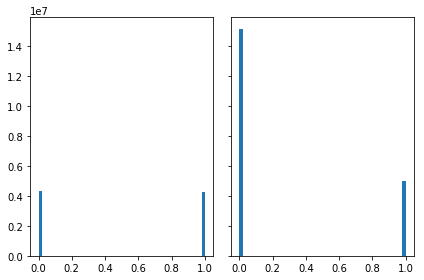

In [21]:
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

seed = 42
def add_nonlinear(df):
    df['X2' ] = df['X' ]**2
    df['Y2' ] = df['Y' ]**2
    df['Z2' ] = df['Z' ]**2
    df['R'  ] = np.sqrt(df['Z2']+
                        df['Y2']+
                        df['Z2'])
    df['angle_xy'] = np.arctan(df['X' ]/df['Y' ])
    df['angle_xz'] = np.arctan(df['X' ]/df['Z' ])
    df['angle_yz'] = np.arctan(df['Y' ]/df['Z' ])
    
    df['dX2'] = df['dX']**2
    df['dY2'] = df['dY']**2
    df['dZ2'] = df['dZ']**2
    df['dR' ] = np.sqrt(df['dZ2']+
                        df['dY2']+
                        df['dZ2'])
    return df

if 0:
    X_train_nl = add_nonlinear(X_train);
    X_test_nl = add_nonlinear(X_test)   
    X_test_nl = X_test_nl[['TX', 'TX_pair', 'TY', 'TY_pair', 'X', 'X_pair', 'Y', 'Y_pair', 'Z', 'Z_pair', 'dTX', 'dTY', 'dX', 'dY', 'dZ', 'X2', 'Y2', 'Z2', 'R', 'dX2', 'dY2', 'dZ2', 'dR', 'angle_xy', 'angle_xz', 'angle_yz']]


# n_features=len(X_train_nl.columns)
# print('Number of rows %d '% n_features)


X_train_xgb,X_val_xgb,y_train_xgb,y_val_xgb   = train_test_split(X_train, y_train, test_size=0.9, random_state=seed)

if 1:
    print('Create, fit and save classifier')
    xgb = XGBClassifier(base_score=0.5,
                        booster='gbtree',
                        colsample_bylevel=1,
                        colsample_bytree=0.8,
                        gamma=0,
                        learning_rate=1/50, 
                        max_delta_step=0,
                        max_depth=15,
                        min_child_weight=1,
                        missing=None,
                        n_estimators=50,
                        n_jobs=-1,
                        nthread=None,
                        objective='binary:logistic',
                        random_state=0,
                        reg_alpha=0.01, 
                        reg_lambda=1, 
                        scale_pos_weight=1, 
                        seed   = None,
                        silent = False, 
                        subsample = 1)
    
    xgb.fit(X_train_xgb, y_train_xgb)
    pickle.dump(xgb, open(("xgb_nestim_%d.dat"%xgb.n_estimators), "wb"))
else :
    print('load model')
    xgb = pickle.load( open( "xgb_nestim_30.dat", "rb" ) )

y_pred_val = xgb.predict(X_val_xgb);
r=roc_auc_score(y_val_xgb, y_pred_val)
print('AUC ROC %2.4f'%r)

probas = xgb.predict(X_test)  
print('Save to file')
save_probas_to_csv(probas,prepared_test=prepared_test)  

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True);
n_bins=50;
axs[0].hist(y_pred_val , bins=n_bins);
axs[1].hist(probas     , bins=n_bins);


Grader output : (roc_auc is 0.751531)